In [42]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random as ra
import math

from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

In [43]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10 #binary for whether it is digit or not
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [44]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [45]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [46]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 128
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #128 - 64
        self.fc2 = nn.Linear(hidden_size1, out_size)       #64 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [48]:
file_pth = 'binary_ffn_all.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained

<All keys matched successfully>

In [49]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.62 %


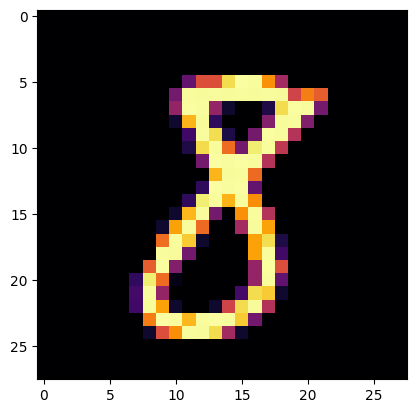

In [50]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 8:
        img = inputs[ind].squeeze()
        break

plt.imshow(img, cmap="inferno")


torch.Size([28, 28])


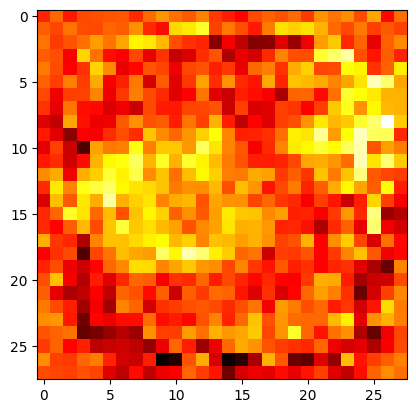

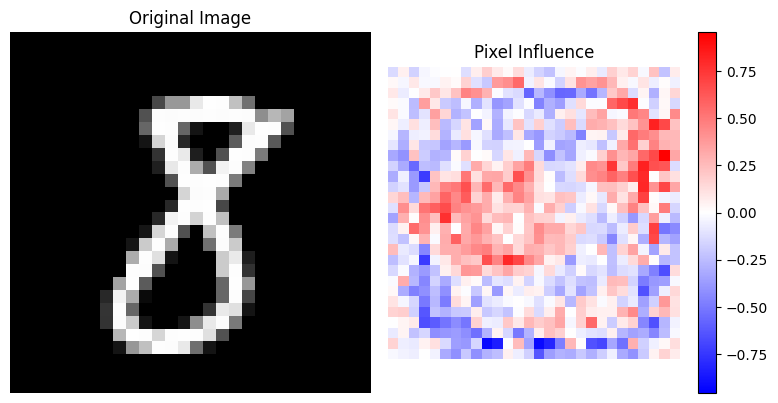

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = img.clone().detach().view(1, -1).to(device).requires_grad_(True)
output = net(x)
target_class = output.argmax(dim=1).item()

net.zero_grad()
output[0, target_class].backward() #gradient for target class with repect to input -> how much each pixel would change the target logit

#saliency = x.grad.data[0, 0]
saliency = x.grad.view(28, 28).cpu() #grads for each pixel

print(saliency.shape)

plt.imshow(saliency, cmap='hot')


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='bwr', vmin=-abs(saliency).max(), vmax=abs(saliency).max())
plt.title("Pixel Influence")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


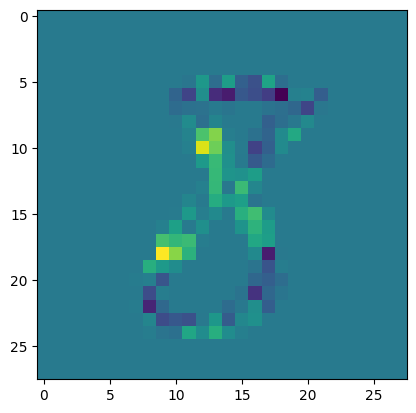

In [52]:
x = img.clone().detach().view(1, -1).to(device).requires_grad_(True)
output = net(x)
target_class = output.argmax(dim=1).item()
net.zero_grad()
output[0, target_class].backward()
attribution = (x.grad * x).view(28, 28)

plt.imshow(attribution.cpu().detach().numpy())

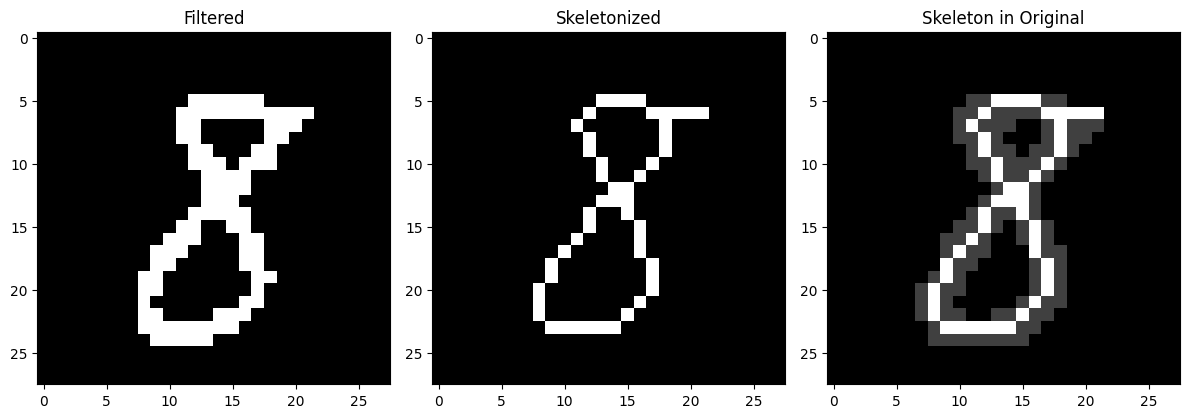

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize


"""inputs, labels = next(iter(test_loader))
dig_to_check = ra.randint(0, 9)

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break"""


img_np = img.cpu().numpy()
filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

skeleton = skeletonize(filtered)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Filtered")
plt.imshow(filtered, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Skeletonized")
plt.imshow(skeleton, cmap='gray')

#is this better than the other method??? update: yeah it actually is, screw the other one


actual = torch.where(
    img == 0,
    torch.tensor(0.0, device=img.device),
    0.25
)

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1

plt.subplot(1, 3, 3)
plt.title("Skeleton in Original")
plt.imshow(actual, cmap="gray")

plt.tight_layout()
plt.show()

Found 431 concept clusters


/tmp/ipykernel_46878/2033237088.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img, device=img.device),


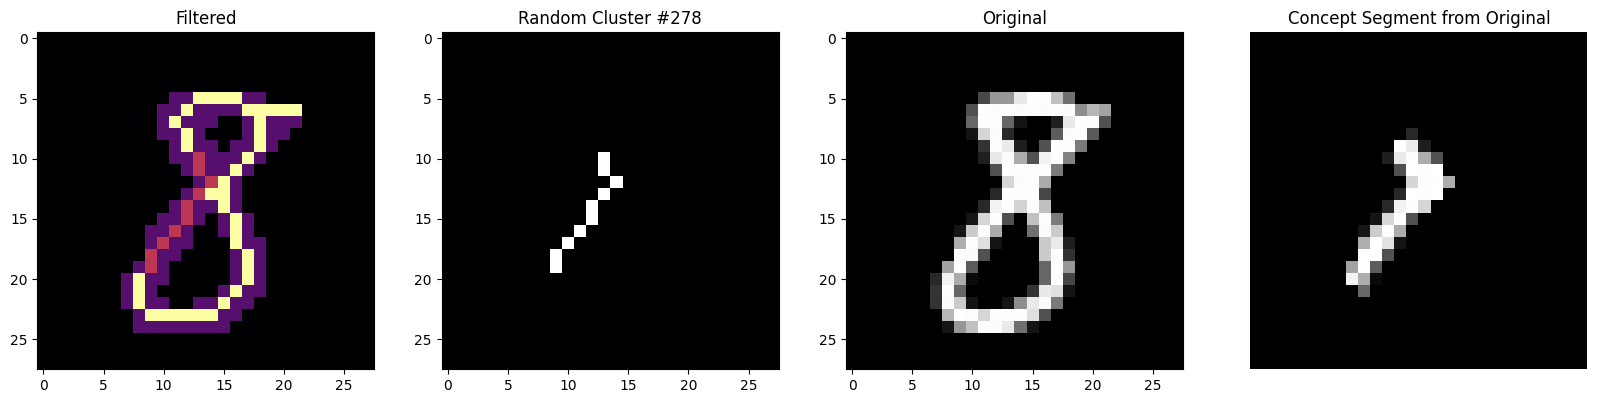

In [54]:
import networkx as nx
from scipy.ndimage import distance_transform_edt

def build_pixel_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape
    for i in range(rows):
        for j in range(cols):
            if skeleton[i, j]:
                G.add_node((i, j))
                for dx in [-1, 0, 1]: #8 neighbors
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < rows and 0 <= nj < cols and skeleton[ni, nj]:
                            G.add_edge((i, j), (ni, nj))
    return G

def find_clusters(G, min_size=5, max_size=10):
    clusters = []
    seen = set()

    def dfs(node, cluster, visited):
        if len(cluster) > max_size:
            return
        cluster_key = tuple(sorted(cluster))
        if cluster_key not in seen and min_size <= len(cluster) <= max_size:
            seen.add(cluster_key)
            clusters.append(cluster.copy())

        for neighbor in G[node]:
            if neighbor not in visited:
                dfs(neighbor, cluster + [neighbor], visited | {neighbor})

    for node in G.nodes:
        dfs(node, [node], set([node]))

    return clusters

def clusters_to_tensor(clusters, shape=(28, 28)):
    masks = []
    for cluster in clusters:
        mask = np.zeros(shape, dtype=np.uint8)
        for (i, j) in cluster:
            mask[i, j] = 1
        masks.append(mask)
    return torch.tensor(np.stack(masks), dtype=torch.uint8).permute(1, 2, 0)

#clustering
G = build_pixel_graph(skeleton)
clusters = find_clusters(G, min_size=10, max_size=10)
cluster_tensor = clusters_to_tensor(clusters) #[28, 28, n]



#plotting stuff:
print(f"Found {cluster_tensor.shape[2]} concept clusters")

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1.0

rand_idx = ra.randint(0, cluster_tensor.shape[2] - 1)
cluster_mask = cluster_tensor[:, :, rand_idx].numpy()
for y, x in np.argwhere(cluster_mask == 1):
    actual[y, x] = 0.5

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Filtered")
plt.imshow(actual, cmap='inferno')

plt.subplot(1, 4, 2)
plt.title(f'Random Cluster #{rand_idx}')
plt.imshow(cluster_tensor[:, :, rand_idx], cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Original')
plt.imshow(img, cmap='gray')

img2 = torch.where(
    img != 0,
    torch.tensor(img, device=img.device),
    0.0
)

inverted_mask = 1 - cluster_mask #cluster mask must be binary for the following methods btw
distance = distance_transform_edt(inverted_mask)
within_range_mask = (distance <= 2).astype(np.float32)
img2 = torch.from_numpy(img_np * within_range_mask) #back to tensor cause I'll give it to the model

plt.subplot(1, 4, 4)
plt.title('Concept Segment from Original')
plt.imshow(img2, cmap='gray')

plt.axis('off')
plt.show()


original_clusters = torch.zeros_like(cluster_tensor)
original_clusters = []

for i in range(cluster_tensor.shape[2]):
    mask = cluster_tensor[:, :, i].numpy()
    inverted_mask = 1 - mask
    distance = distance_transform_edt(inverted_mask)
    within_range_mask = (distance <= 2).astype(np.float32)
    new_input = torch.from_numpy(img_np * within_range_mask).float()
    original_clusters.append(new_input)
    
#plt.imshow(original_clusters[ra.randint(0, cluster_tensor.shape[2])])



While doing the segmentation search on the original input would have also worked, it would have been far less efficient, as it would have also tried out different lanes on the (topologically) R¹ structure, in other words: it would have been R²

In [55]:
#don't forget to add lines or even smooth functions (instead of pixels) later for cleaner visualisation!
#now find concepts of cluster combinations that optimally activate the FFN final predcition probability distributions!

In [56]:
#model prep, no eval:

with torch.no_grad():
    activations_this_class = []
    for input_mat in original_clusters:
        if CUDA:
            input_mat = input_mat.cuda()

        a0 = F.tanh(net.fc0(input_mat.float().view(-1)))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)

        prob_distr = torch.sigmoid(logits/5)

        confidence = (1 * torch.max(prob_distr) - 0.1 * (torch.sum(prob_distr))) #how much the predicted class was activation relative to the average activaion of all other classes

        activations_this_class.append(confidence) #torch.max(prob_distr))

        #print(logits)

    scalars = [x.item() for x in activations_this_class]
    min_val = min(scalars)
    max_val = max(scalars)

    print(min_val, max_val)

    zero_point = min_val + (max_val-min_val)/2
    max_factor = 1/(max_val-zero_point)

    print(max_factor * (max_val - zero_point))

    """        scalars = [x.item() for x in activations_this_class]
            min_val = min(scalars)
            max_val = max(scalars)
            range_local = max_val - min_val

            for i, act in enumerate(activations_this_class):
                activations_this_class[i] = torch.tanh((max_val-act) / (act-min_val-0.0001) - 1 )    #2 * (act - min_val) / range_local - 1
    """

    print(activations_this_class[0])



def normalise_importance(val):
    return max_factor * (val - zero_point)








0.04091686010360718 0.2112281620502472
1.0
tensor(0.1188, device='cuda:0')


In [57]:
ind_n = 0

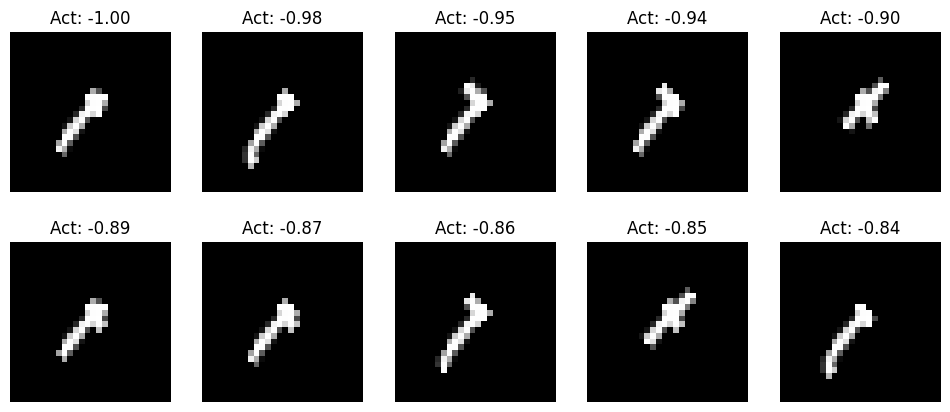

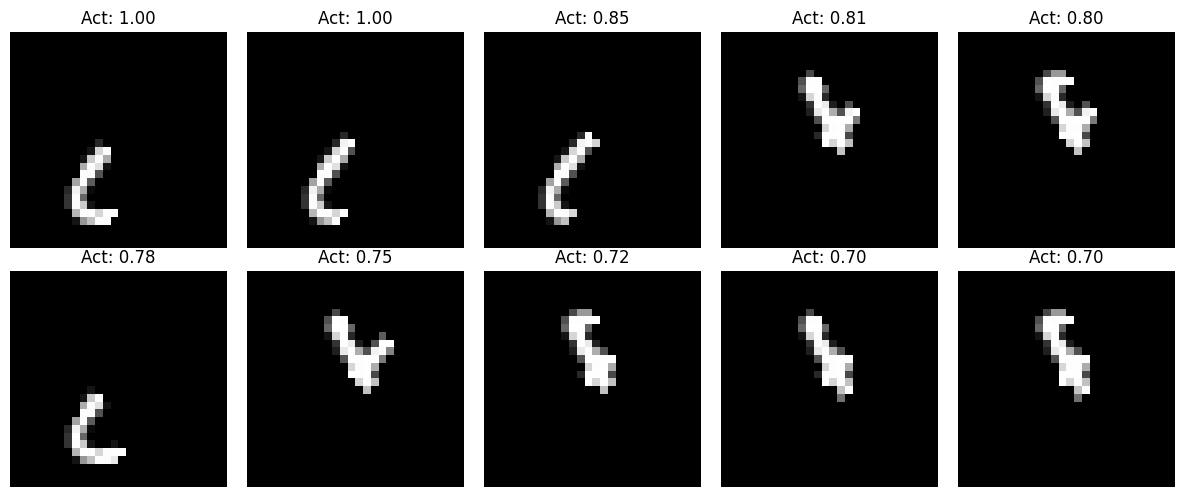

'plt.imshow(original_clusters[ind_n], cmap="gray")\nplt.title(f"Act: {normalise_importance(activations[ind_n]):.2f}")\nind_n += 1'

In [58]:
#get highest actiations and plot the corresponding img:

activations = torch.tensor([a.item() for a in activations_this_class])

last10_values, last10_indices = torch.topk(activations, 10, largest=False)
last10_tensors = [original_clusters[idx] for idx in last10_indices]

top10_values, top10_indices = torch.topk(activations, 10, largest=True)
top10_tensors = [original_clusters[idx] for idx in top10_indices]


fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()


for i, ax in enumerate(axs):
    im = last10_tensors[i]
    ax.imshow(im.numpy(), cmap='gray')
    ax.set_title(f"Act: {normalise_importance(last10_values[i]):.2f}")
    ax.axis('off')

fig2, axs2 = plt.subplots(2, 5, figsize=(12, 5))
axs2 = axs2.flatten()

for i, ax in enumerate(axs2):
    im = top10_tensors[i]
    ax.imshow(im.numpy(), cmap='gray')
    ax.set_title(f"Act: {normalise_importance(top10_values[i]):.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


"""plt.imshow(original_clusters[ind_n], cmap="gray")
plt.title(f"Act: {normalise_importance(activations[ind_n]):.2f}")
ind_n += 1"""


next problem: many concepts overlap, but I do see which combnations of pixels that form low-level concepts have the most influence and in what direction they do
--> I have to find these concepts that cover the entire digit and have the stringest influence in either direction (either class)

pseudo code plan:

take absoulte values of all influences (still keep data about direction) because some parts may not have one specific influence, wouldn't make sense to look for inly specific influence
-> then start with highest value concept (add it to concept list)
-> find next biggest value of a concept that doesn't exceed a threshold of overlaping with any non-zeor pixels in matrices of concept list
-> do this until no matching matrix is found

then plot the found concepts in different color, with the white original in the background in case of spots that aren't covered by a concept
-> colors must correspond to strength of influence and direction, e.g. green for high activation value, red low activation value, saturation = abs value




In [59]:
def get_unique_concepts(original_clusters, activations, overlap_threshold):
    activations = torch.tensor(activations)
    abs_activations = activations.abs()
    sorted_indices = torch.argsort(abs_activations, descending=True)
    selected_indices = []
    #first_mask = torch.zeros_like(original_clusters[0]).bool()
    #plt.imshow(combined_mask)

    for i, idx in enumerate(sorted_indices):
        concept_mask = original_clusters[idx] != 0

        if i == 0:
            comp_mask = original_clusters[0] != 0
            selected_indices.append(idx.item())

        similarities = []
        for ind in selected_indices:
            comp_mask = original_clusters[ind] != 0
            normaliser = concept_mask.sum().float() if concept_mask.sum().float() < comp_mask.sum().float() else comp_mask.sum().float()
            similarities.append((concept_mask & comp_mask).sum().float() / normaliser)

        similarity = max(similarities) #(concept_mask & comp_mask).sum().float() / concept_mask.sum().float()

        if concept_mask.sum() != 0 and similarity < overlap_threshold: #0.4:
            comp_mask = concept_mask
            selected_indices.append(idx.item())

    return selected_indices




Selected concept indices: [415, 101, 23, 423]
0.2112281620502472


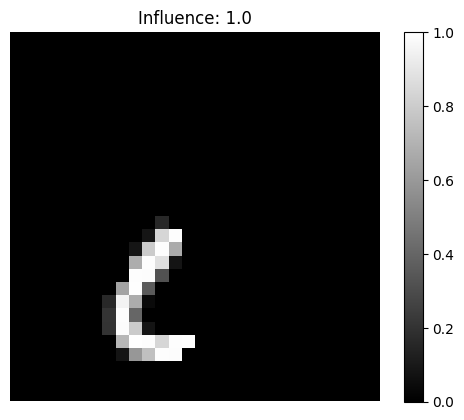

0.19545963406562805


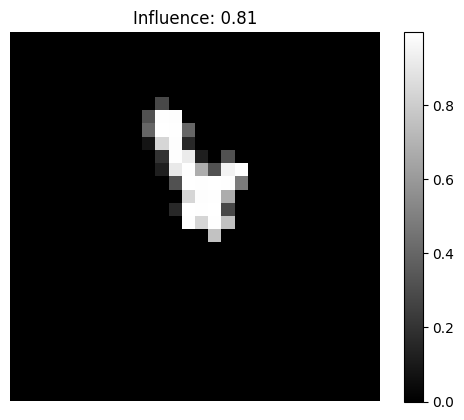

0.14228779077529907


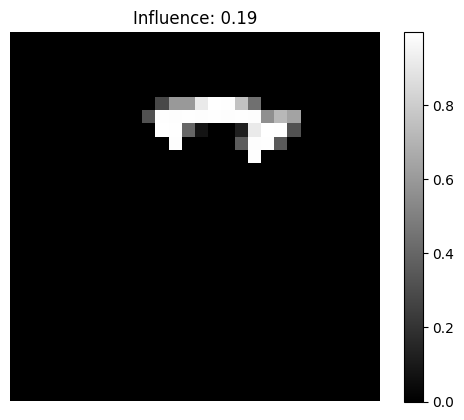

0.11714878678321838


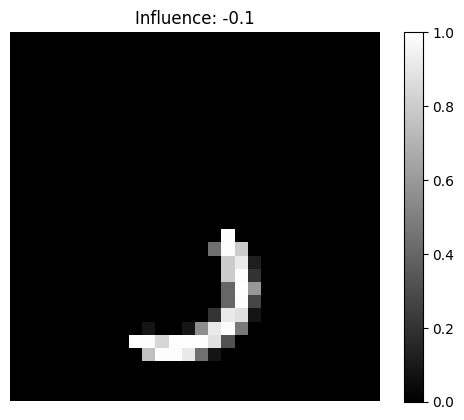

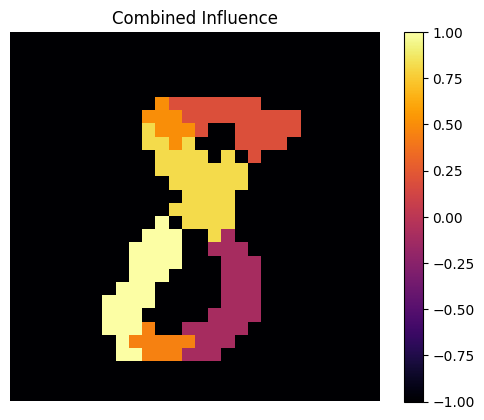

In [60]:
overlap_threshold = 0.25 #this is not being used, it is 40% by default
selected_indices = get_unique_concepts(original_clusters, activations_this_class, overlap_threshold)
print("Selected concept indices:", selected_indices)

#combined = np.zeros_like(original_clusters[0], dtype=float)
combined = np.full_like(original_clusters[0], fill_value=-1.0, dtype=float)


for idx in selected_indices:
    mat = original_clusters[idx]
    value = activations_this_class[idx].item()
    title = f"Influence: {round(normalise_importance(value), 2)}"

    print(value)

    plt.figure()
    plt.imshow(mat, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
    plt.show()

    #mask = (mat!= 0) & (combined == 0)
    #combined[mask] = normalise_importance(value)
    new_vals = normalise_importance(value)
    mask = (mat != 0)
    combined[mask] = np.where(
        combined[mask] == -1,
        new_vals,
        (combined[mask] + new_vals) / 2
    )

    
    #combined[mat != 0] = normalise_importance(value)

plt.figure()
plt.imshow(combined, cmap='inferno', vmin=-1, vmax=1)
plt.title("Combined Influence")
plt.colorbar()
plt.axis('off')
plt.show()

#NOTE: IF NEGATIVELY (OR POSITIVELY) INFLUENCING CONEPTS ARE NOT TOO STRONG, IT MAY BE DUE TO PREVENTION OF OVERLAP,
#BUT STILL SHOW ACURATE SEGMENTATION, BECAUSE OVERLAP WITH STRONG POSITIVE CONCEPT MEANS THE PARTS ARE ONLY STRONG IN CERTAIN CONCEPTS, NOT ONLY THOUGH

#following skeleton clusters should all have same size

In [61]:
#also: collect importance for each pixel from the conept importances: will give pixel importance for conepts, not just model

In [62]:
def select_non_overlapping_concepts(original_clusters, activations, overlap_threshold=0.1):
    activations = torch.tensor(activations)
    n = activations.shape[0]
    abs_activations = activations.abs()
    sorted_indices = torch.argsort(abs_activations, descending=True)
    selected_indices = []
    combined_mask = torch.zeros_like(original_clusters[0]).bool()

    for idx in sorted_indices:
        concept_mask = original_clusters[idx] != 0
        if concept_mask.sum() == 0:
            continue
        overlap = (concept_mask & combined_mask).sum().float() / concept_mask.sum().float()
        if overlap <= overlap_threshold:
            selected_indices.append(idx.item())
            combined_mask = combined_mask | concept_mask

    return selected_indices

def plot_concepts_with_influence(original_image, original_clusters, activations, selected_indices):
    activations = torch.tensor(activations)
    canvas = np.stack([original_image]*3, axis=-1)
    max_abs = activations.abs().max().item()
    
    if max_abs == 0:
        max_abs = 1.0

    for idx in selected_indices:
        cluster = original_clusters[idx].cpu().numpy()
        mask = cluster != 0
        influence = activations[idx].item()
        color = np.array([1,0,0]) if influence < 0 else np.array([0,1,0])
        saturation = min(abs(influence)/max_abs,1.0)
        for c in range(3):
            canvas[:,:,c][mask] = saturation*color[c] + (1-saturation)*canvas[:,:,c][mask]

    plt.figure(figsize=(5,5))
    plt.imshow(canvas)
    plt.axis('off')
    plt.title("Selected Concepts + Influence Color")
    plt.show()


Selected concept indices: [415, 101, 23, 423]


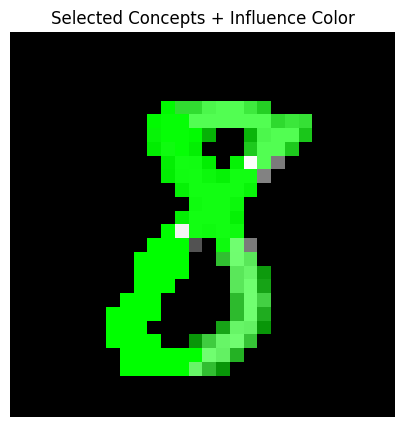

In [63]:
overlap_threshold = 0.25
selected_indices = select_non_overlapping_concepts(original_clusters, activations_this_class, overlap_threshold)
print("Selected concept indices:", selected_indices)

plot_concepts_with_influence(img, original_clusters, activations_this_class, selected_indices)


In [64]:
#this shows me conceptually wihch parts have what influence on a models prediction, by passing only these parts through the model, here displaying the most important (i.e. highest activating) segments,
#optimally covering most of the digit. This would be quite hard without first segmenting into concepts, as passing through pixels on their own would result in very scattered attributions across many neurons
#and a prediction on just one pixel would not carry enough meaning. The concepts tell me how the model interprets each part of the input, regarding the influence on the probability distribuition for class predctions
#red = strongly against it being the learnt digit, green = strongly for -> red can clearly be found in opther ditgits quite frequently, green is more unique to this digit

In [65]:
pixel_count_important = (img > 0).sum().item()
segment_size = round(pixel_count_important * 0.04, 0)

imp_pixels = (img > 0.5).nonzero(as_tuple=False) #tensor of coordiantes that aren't = 0 (just which pixels are to be clustered)

pixel_count_important, segment_size


(148, 6.0)

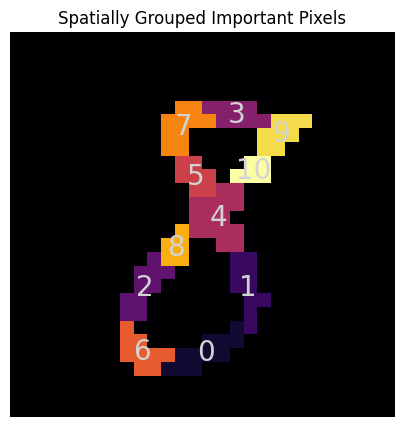

In [66]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=segment_size,
    linkage='complete',
    metric='euclidean'
)
labels = clusterer.fit_predict(imp_pixels) #apply clusterer to img

clusters = defaultdict(list)
for coord, label in zip(imp_pixels, labels):
    clusters[label].append(coord) #data structure to assign label to each group of pixles

#making a map
label_map = torch.zeros((28, 28), dtype=torch.int32)
for label, coords in clusters.items():
    for y, x in coords:
        label_map[y, x] = label + 1

label_map_np = label_map.numpy()
unique_vals = np.unique(label_map_np)

plt.figure(figsize=(5, 5))
plt.imshow(label_map_np, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Spatially Grouped Important Pixels')

for val in unique_vals:
    positions = np.argwhere(label_map_np == val)
    if positions.size == 0 or val == 0:
        continue
    centroid = positions.mean(axis=0)
    y, x = centroid
    plt.text(x, y, str(val-1), color='lightgray', fontsize=20, ha='center', va='center')

plt.show()


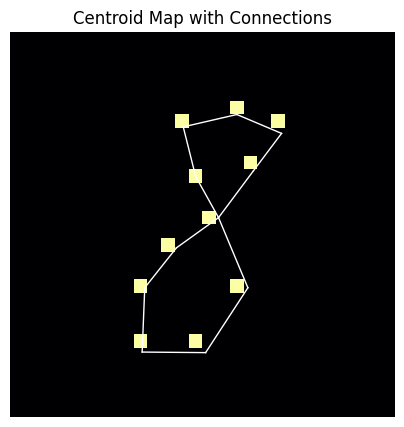

In [67]:
from scipy.ndimage import binary_dilation

#centroids
centroids = {}
for label, coords in clusters.items():
    centroids[label] = np.mean(coords, axis=0)  #(y,x) because np, matplot etc... order by row then column -> y then x

#touch detection
structure = np.ones((3,3), dtype=bool) #bin dilation checks for all 8 connected neighbors, therefore 3x3
touching = set()
for l1, c1 in clusters.items():
    mask = np.zeros((28,28), dtype=bool)
    for y,x in c1: mask[y,x]=1
    dil = binary_dilation(mask, structure=structure)
    for l2, c2 in clusters.items():
        if l1>=l2: continue
        if any(dil[y,x] for y,x in c2): touching.add((l1,l2)) #which labels touch

#centroid map
centroid_map = torch.zeros((28,28), dtype=torch.float32)
for l, (y,x) in centroids.items():
    centroid_map[int(y), int(x)] = 1

#plot map
plt.figure(figsize=(5,5))
plt.imshow(centroid_map, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Centroid Map with Connections')

#draw lines
for l1,l2 in touching:
    y1,x1 = centroids[l1]
    y2,x2 = centroids[l2]
    plt.plot([x1,x2], [y1,y2], color='white', linewidth=1)


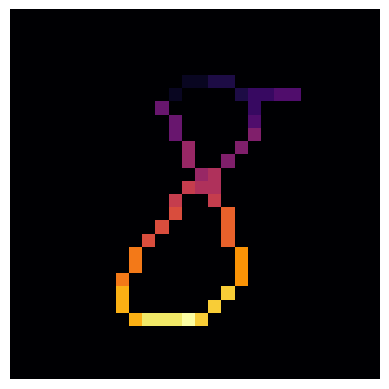

In [68]:
used = set()
groups = []
pixels = set(zip(y_true, x_true))

for y, x in zip(y_true, x_true):
    if (y, x) in used:
        continue
    
    group = [(y, x)]
    used.add((y, x))
    
    for ny, nx in [(y+i, x+j) for i in [-1,0,1] for j in [-1,0,1]]: #check all 8 neighbors
        if (ny, nx) not in used and 0 <= ny < 28 and 0 <= nx < 28 and (ny, nx) in pixels:
            group.append((ny, nx))
            used.add((ny, nx))
    
    if len(group) < 3:
        for ny, nx in [(y+i, x+j) for i in range(-2,3) for j in range(-2,3)]: #checking 14 neighbors in next outer layer
            if len(group) >= 3: #try exactly 3
                break
            if (ny, nx) not in used and 0 <= ny < 28 and 0 <= nx < 28 and (ny, nx) in pixels:
                group.append((ny, nx))
                used.add((ny, nx))
    
    groups.append(group)

color_map = np.zeros((28, 28))
for n, group in enumerate(groups):
    for y, x in group:
        color_map[y, x] = n + 1

plt.imshow(color_map, cmap='inferno')
plt.axis('off')
plt.show()


In [69]:
#ok these last 3 plots were not useful at all